In [2]:
# Dependencies
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.words import load_data, words_extraction
from modules.hashtags import show_counts, filter_dataset, splitter, save_splitting, hashtags_extraction

%matplotlib inline

[nltk_data] Downloading package wordnet to /home/laura/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/laura/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Hashatag analysis

### Whole dataset

In [3]:
tweets_all = { 2018 : pd.read_json('./data/tweets_preGreta.json',
                                    dtype = { 'id': np.unicode_}),
               2019 : pd.read_json('./data/tweets_postGreta.json',
                                    dtype = { 'id': np.unicode_})
             }

In [4]:
# inputs: dataframes, words on which filter
show_counts(tweets_all, [])

hashtag frequencies in 2018: 

 {'climatechange': 8841, 'climatecrisis': 36, 'parisagreement': 1130, 'gretathunberg': 0, 'climatestrike': 0, 'fridays4future': 0}

hashtag frequencies in 2019: 

 {'climatechange': 6411, 'climatecrisis': 831, 'parisagreement': 202, 'gretathunberg': 146, 'climatestrike': 1645, 'fridays4future': 65}



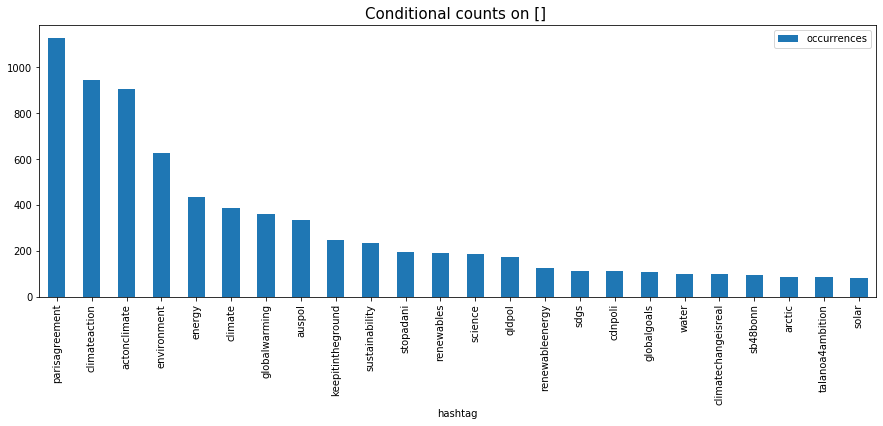

In [5]:
top_hash_pre = filter_dataset(tweets_all[2018], year=2018, words=[], n_max=25, n_min=1)

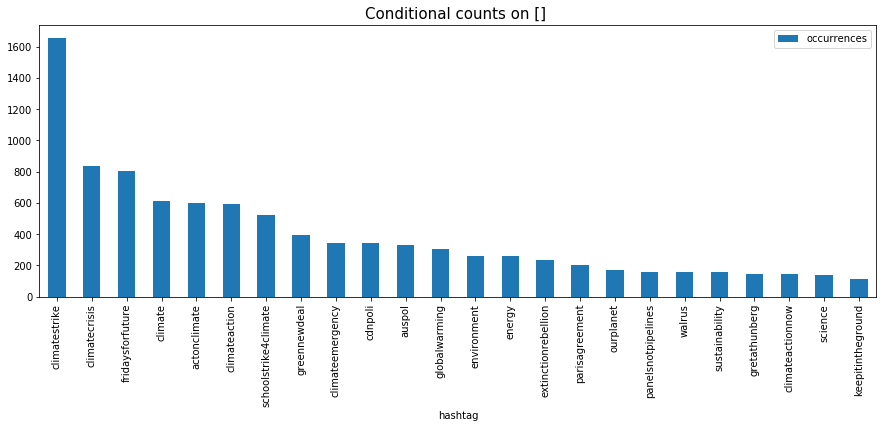

In [6]:
top_hash_post = filter_dataset(tweets_all[2019], year=2019, words=[], n_max=25, n_min=1)

### ClimateChange dataset

In [7]:
# unique dataset with all periods
tweets = load_data('data/dataset/tweets_climatechange.json')

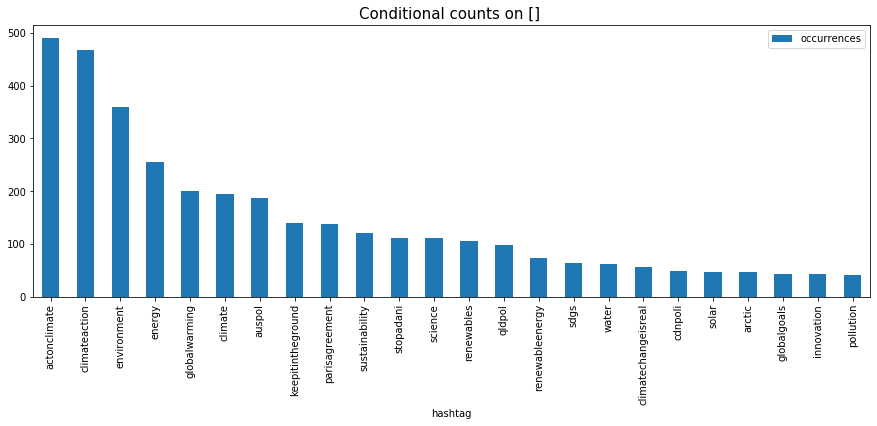

In [8]:
hash_pre_climate = filter_dataset(tweets, year=2018, words=[], n_max=25, n_min=1)

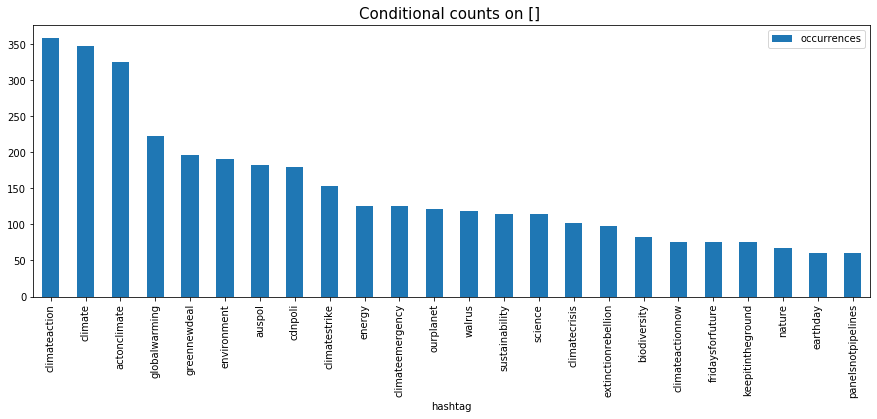

In [9]:
hash_post_climate = filter_dataset(tweets, year=2019, words=[], n_max=25, n_min=1)

In [10]:
hash_pre_climate.head()

,hashtag,occurrences
1,climatechange,5035
65,actonclimate,491
3,climateaction,467
51,environment,360
114,energy,256


### Split hashtags

In [11]:
splitted = splitter(hash_pre_climate, hash_post_climate, save = True)
splitted.head()

              word     proposed_splitting  count_pre  count_post
0     speakenglish                    NaN          1         NaN
1          million                    NaN          2         NaN
2     consequences                    NaN          1         NaN
3        bankimoon  ['bank', 'i', 'moon']          1         NaN
4  carstrikefriday                    NaN          1         NaN


,word,proposed_splitting,count_pre,count_post
0,speakenglish,NaN,1,NaN
1,million,NaN,2,NaN
2,consequences,NaN,1,NaN
3,bankimoon,"['bank', 'i', 'moon']",1,NaN
4,carstrikefriday,NaN,1,NaN


### Select most frequent hashtag to be splitted manually

In [12]:
# Join top_hash pre and post
top_hash = hash_pre_climate.set_index("hashtag").join(hash_post_climate.set_index("hashtag"), how="outer", lsuffix="pre", rsuffix="post")

# Remove nans and sum occurrences
top_hash[top_hash.isna()] = 0
top_hash["occurrences_tot"] = top_hash.occurrencespre + top_hash.occurrencespost

# Format (and save) the splitted dataset for the top hashtags
top_splitted = splitted.join(top_hash, on="word", how="right")

# Sort the hashtags according to frequency
top_splitted = top_splitted.sort_values(by="occurrences_tot", ascending=False)

# Remove useless columns
top_splitted = top_splitted[["word", "proposed_splitting"]]

# Select and save top 400 frequent values
bottom_splitted = top_splitted[400:]
top_splitted = top_splitted[:400]
# top_splitted.to_csv("data/top_400_hashtags_raw.tsv", sep='\t')

Once the dataframe containing most frequent hashtags has been manually corrected, it can be loaded and converted into a dictionary

In [13]:
# Load the dataset - manually updated
top_splitted = pd.read_csv("data/top_400_hashtags.tsv", sep='\t').iloc[:,:2]
# Save in a .py file the dictionary of manually+automatically split hashtags
save_splitting(top_splitted, bottom_splitted)

## Dataset creation

Once the words are extracted, they are stored in a Pandas DataFrame with the following attributes:

1. <code> id </code> : Reference to the tweet ID
2. <code> index </code> : Position of the word in the sentence (tweet) - useful to delete self loops
3. <code> text </code> : Actual word
4. <code> pos </code> : Part Of Speech tag
5. <code> conf </code> : Confidence associated to the POS tag

In [ ]:
hashtags_extraction(tweets)

In [14]:
#extraction(tweets, 0.95)

         hashtag                  id
0  globalwarming  988241915412873216
1  climatechange  988241915412873216
2       earthday  988241915412873216
3  climatechange  988241946073321472
4  climateaction  988241946073321472


Final number of hashtags:  35499
